# Proyecto NLP E3 - Análisis de Noticias Financieras

Este notebook implementa un sistema de análisis de noticias financieras multilingüe con tres tareas principales:

1. **Normalización Lingüística**: Traducción de noticias de múltiples idiomas al inglés
2. **Detección de Consistencia**: Clasificación binaria (correcta/incorrecta)
3. **Análisis de Sentimiento**: Clasificación multiclase (positivo/negativo/neutral)

## Pipeline de datos:
- **Input inicial**: `data/initial_data.csv` - Dataset original de noticias financieras en español
- **Paso 1**: Mezcla de datos - Creación de noticias "incorrectas" combinando fragmentos de sentimientos opuestos
- **Paso 2**: Traducción multiidioma - Traducción a 9 idiomas (ES, EN, FR, DE, IT, PT, CA, EU, GL)
- **Output**: Dataset multiidioma con ~10,644 noticias

**Modelos a entrenar**:
- Shallow Learning: Logistic Regression, SVM, Random Forest, Naive Bayes
- Deep Learning: LSTM, CNN, Bi-LSTM+Attention
- Transformers: BERT multilingual, FinBERT

In [1]:
# ==============================================================================
# SETUP - Instalación de Dependencias y Configuración
# ==============================================================================

# Instalación de librerías (descomentar si es necesario)
# !pip install deep-translator pandas tqdm seaborn nltk scikit-learn gensim matplotlib numpy transformers torch tensorflow

import warnings
warnings.filterwarnings('ignore')

# Imports principales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import os
import random
import re
import string

# Crear directorios si no existen
os.makedirs('data', exist_ok=True)
os.makedirs('data_processed', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('charts', exist_ok=True)

# Configuración de reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# Configuración de visualización
sns.set_theme(style="whitegrid", palette="husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("=" * 60)
print("SETUP COMPLETADO")
print("=" * 60)
print("\nEstructura de carpetas:")
print("  📁 data/              - Datasets originales e intermedios")
print("  📁 data_processed/    - Datos procesados (CSV, NPZ)")
print("  📁 models/            - Modelos entrenados y vectorizadores")
print("  📁 charts/            - Gráficos y visualizaciones")

SETUP COMPLETADO

Estructura de carpetas:
  📁 data/              - Datasets originales e intermedios
  📁 data_processed/    - Datos procesados (CSV, NPZ)
  📁 models/            - Modelos entrenados y vectorizadores
  📁 charts/            - Gráficos y visualizaciones


---
# Parte 1: Preparación de Datos

En esta sección se realiza el pipeline completo de preparación de datos:

1. **1.1 Carga del Dataset Original**: Lectura de `initial_data.csv`
2. **1.2 Mezcla de Datos**: Creación de noticias "incorrectas" para la tarea de consistencia
3. **1.3 Traducción Multiidioma**: Traducción automática a 9 idiomas
4. **1.4 Análisis Exploratorio (EDA)**: Estadísticas y visualizaciones
5. **1.5 Preprocesamiento de Texto**: Tokenización, limpieza, lematización

## 1.1 Carga del Dataset Original

El dataset original (`initial_data.csv`) contiene noticias financieras en español con etiquetas de sentimiento (positive/negative/neutral).

In [2]:
# ==============================================================================
# 1.1 CARGA DEL DATASET ORIGINAL
# ==============================================================================

# Cargar dataset original
df_original = pd.read_csv('data/initial_data.csv')

print("=" * 60)
print("DATASET ORIGINAL CARGADO")
print("=" * 60)
print(f"\nTotal de noticias: {len(df_original)}")
print(f"Columnas: {list(df_original.columns)}")

print("\nDistribución de sentimientos:")
print(df_original['Sentiment'].value_counts())

print("\nPrimeras filas del dataset:")
df_original.head()

DATASET ORIGINAL CARGADO

Total de noticias: 5842
Columnas: ['Sentence', 'Sentiment']

Distribución de sentimientos:
Sentiment
neutral     3130
positive    1852
negative     860
Name: count, dtype: int64

Primeras filas del dataset:


,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


## 1.2 Mezcla de Datos - Creación de Noticias Incorrectas

Para la tarea de **Detección de Consistencia**, necesitamos crear noticias "incorrectas" que contengan información contradictoria.

**Metodología**:
- Las noticias **correctas** son las originales (50% del dataset final)
- Las noticias **incorrectas** se crean mezclando fragmentos de noticias con sentimientos opuestos (50% del dataset final)
- Esto genera incoherencia semántica que el modelo debe detectar

In [3]:
# ==============================================================================
# 1.2 MEZCLA DE DATOS - CREACIÓN DE NOTICIAS INCORRECTAS
# ==============================================================================

def extraer_fragmentos(noticia):
    """
    Extrae fragmentos de una noticia dividiendo por comas o puntos.
    Esto permite crear mezclas más naturales de textos.
    """
    # Primero intentar dividir por comas
    fragmentos = [p.strip() for p in noticia.split(',') if p.strip()]
    
    # Si no hay suficientes fragmentos, dividir por puntos
    if len(fragmentos) <= 1:
        fragmentos = [p.strip() for p in noticia.split('.') if p.strip()]
    
    return fragmentos


def crear_mezclas_opuestas(df_positive, df_negative, num_mezclas):
    """
    Crea noticias incorrectas mezclando fragmentos de noticias 
    con sentimientos opuestos (positivo + negativo).
    
    Args:
        df_positive: DataFrame con noticias positivas
        df_negative: DataFrame con noticias negativas
        num_mezclas: Número de noticias incorrectas a crear
    
    Returns:
        DataFrame con noticias mezcladas etiquetadas como 'incorrecta'
    """
    noticias_mezcladas = []
    
    print(f"\nCreando {num_mezclas} mezclas de sentimientos opuestos...")
    
    for i in range(num_mezclas):
        if (i + 1) % 1000 == 0:
            print(f"  Procesadas {i + 1}/{num_mezclas}...")
        
        # Seleccionar una noticia positiva y una negativa aleatoriamente
        idx_pos = random.randint(0, len(df_positive) - 1)
        idx_neg = random.randint(0, len(df_negative) - 1)
        
        noticia_pos = df_positive.iloc[idx_pos]['Sentence']
        noticia_neg = df_negative.iloc[idx_neg]['Sentence']
        
        # Extraer fragmentos de cada noticia
        frag_pos = extraer_fragmentos(noticia_pos)
        frag_neg = extraer_fragmentos(noticia_neg)
        
        # Seleccionar 1-2 fragmentos de cada noticia
        if len(frag_pos) > 0 and len(frag_neg) > 0:
            num_pos = min(random.randint(1, 2), len(frag_pos))
            num_neg = min(random.randint(1, 2), len(frag_neg))
            
            fragmentos_seleccionados = (
                random.sample(frag_pos, num_pos) + 
                random.sample(frag_neg, num_neg)
            )
            
            # Mezclar el orden de los fragmentos
            random.shuffle(fragmentos_seleccionados)
            
            # Unir fragmentos
            noticia_mezclada = ', '.join(fragmentos_seleccionados)
            if noticia_mezclada and noticia_mezclada[-1] not in '.!?':
                noticia_mezclada += '.'
            
            # Asignar sentimiento aleatorio (ya que es inconsistente)
            sentiment = random.choice(['positive', 'negative'])
            
            noticias_mezcladas.append({
                'Sentence': noticia_mezclada,
                'Sentiment': sentiment,
                'Etiqueta': 'incorrecta'
            })
    
    return pd.DataFrame(noticias_mezcladas)


# Verificar si ya existe el dataset mezclado
if os.path.exists('data/dataset_mezclado_final.csv'):
    print("Dataset mezclado ya existe. Cargando...")
    df_mezclado = pd.read_csv('data/dataset_mezclado_final.csv')
else:
    print("Creando dataset mezclado desde cero...")
    
    # Crear copia para noticias correctas (50%)
    df_correctas = df_original.copy()
    df_correctas['Etiqueta'] = 'correcta'
    
    # Separar noticias por sentimiento
    df_positive = df_original[df_original['Sentiment'] == 'positive']
    df_negative = df_original[df_original['Sentiment'] == 'negative']
    
    print(f"\nNoticias positivas disponibles: {len(df_positive)}")
    print(f"Noticias negativas disponibles: {len(df_negative)}")
    
    # Crear el mismo número de noticias incorrectas que correctas
    num_mezclas = len(df_correctas)
    df_incorrectas = crear_mezclas_opuestas(df_positive, df_negative, num_mezclas)
    
    # Combinar datasets
    df_mezclado = pd.concat([df_correctas, df_incorrectas], ignore_index=True)
    
    # Mezclar aleatoriamente
    df_mezclado = df_mezclado.sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)
    
    # Guardar dataset mezclado
    df_mezclado.to_csv('data/dataset_mezclado_final.csv', index=False, encoding='utf-8')
    print(f"\nDataset guardado en 'data/dataset_mezclado_final.csv'")

# Mostrar estadísticas
print("\n" + "=" * 60)
print("ESTADÍSTICAS DEL DATASET MEZCLADO")
print("=" * 60)
print(f"Total de filas: {len(df_mezclado)}")
print(f"Noticias correctas: {len(df_mezclado[df_mezclado['Etiqueta'] == 'correcta'])} ({len(df_mezclado[df_mezclado['Etiqueta'] == 'correcta'])/len(df_mezclado)*100:.1f}%)")
print(f"Noticias incorrectas: {len(df_mezclado[df_mezclado['Etiqueta'] == 'incorrecta'])} ({len(df_mezclado[df_mezclado['Etiqueta'] == 'incorrecta'])/len(df_mezclado)*100:.1f}%)")

print(f"\nDistribución de sentimientos en noticias CORRECTAS:")
print(df_mezclado[df_mezclado['Etiqueta'] == 'correcta']['Sentiment'].value_counts())

print(f"\nDistribución de sentimientos en noticias INCORRECTAS:")
print(df_mezclado[df_mezclado['Etiqueta'] == 'incorrecta']['Sentiment'].value_counts())

Creando dataset mezclado desde cero...

Noticias positivas disponibles: 1852
Noticias negativas disponibles: 860

Creando 5842 mezclas de sentimientos opuestos...
  Procesadas 1000/5842...
  Procesadas 2000/5842...
  Procesadas 3000/5842...
  Procesadas 4000/5842...
  Procesadas 5000/5842...

Dataset guardado en 'data/dataset_mezclado_final.csv'

ESTADÍSTICAS DEL DATASET MEZCLADO
Total de filas: 11684
Noticias correctas: 5842 (50.0%)
Noticias incorrectas: 5842 (50.0%)

Distribución de sentimientos en noticias CORRECTAS:
Sentiment
neutral     3130
positive    1852
negative     860
Name: count, dtype: int64

Distribución de sentimientos en noticias INCORRECTAS:
Sentiment
negative    2940
positive    2902
Name: count, dtype: int64


In [4]:
# Mostrar ejemplos de noticias correctas e incorrectas
print("=" * 60)
print("EJEMPLOS DE NOTICIAS")
print("=" * 60)

print("\n[NOTICIA CORRECTA]")
ejemplo_correcta = df_mezclado[df_mezclado['Etiqueta'] == 'correcta'].iloc[0]
print(f"Sentimiento: {ejemplo_correcta['Sentiment']}")
print(f"Texto: {ejemplo_correcta['Sentence'][:300]}{'...' if len(ejemplo_correcta['Sentence']) > 300 else ''}")

print("\n" + "-" * 60)

print("\n[NOTICIA INCORRECTA - Ejemplo 1]")
ejemplo_inc1 = df_mezclado[df_mezclado['Etiqueta'] == 'incorrecta'].iloc[0]
print(f"Sentimiento asignado: {ejemplo_inc1['Sentiment']}")
print(f"Texto mezclado: {ejemplo_inc1['Sentence'][:300]}{'...' if len(ejemplo_inc1['Sentence']) > 300 else ''}")

print("\n[NOTICIA INCORRECTA - Ejemplo 2]")
ejemplo_inc2 = df_mezclado[df_mezclado['Etiqueta'] == 'incorrecta'].iloc[50]
print(f"Sentimiento asignado: {ejemplo_inc2['Sentiment']}")
print(f"Texto mezclado: {ejemplo_inc2['Sentence'][:300]}{'...' if len(ejemplo_inc2['Sentence']) > 300 else ''}")

EJEMPLOS DE NOTICIAS

[NOTICIA CORRECTA]
Sentimiento: neutral
Texto: The presentation material can be viewed on the company 's website in English after the conference .

------------------------------------------------------------

[NOTICIA INCORRECTA - Ejemplo 1]
Sentimiento asignado: negative
Texto mezclado: BasWare succeeded well in the second quarter of 2007 ., `` Operating profit declined mainly due to the increased cost of wood and recycled fiber and the strengthened euro.

[NOTICIA INCORRECTA - Ejemplo 2]
Sentimiento asignado: negative
Texto mezclado: Pretax profit rose to EUR 17, 9 million USD 137.


## 1.3 Traducción Multiidioma

Traducimos el dataset a múltiples idiomas para crear un corpus multilingüe que permita:
- Evaluar la robustez de los modelos ante diferentes idiomas
- Practicar la tarea de normalización lingüística (traducción al inglés)

**Idiomas objetivo**: español (es), inglés (en), francés (fr), alemán (de), italiano (it), portugués (pt), catalán (ca), euskera (eu), gallego (gl)

**Herramienta**: Google Translator via `deep-translator`

In [ ]:
# ==============================================================================
# 1.3 TRADUCCIÓN MULTIIDIOMA
# ==============================================================================

from tqdm import tqdm

# Diccionario de idiomas
IDIOMAS = {
    'es': 'español',
    'en': 'inglés',
    'fr': 'francés',
    'de': 'alemán',
    'it': 'italiano',
    'pt': 'portugués',
    'ca': 'catalán',
    'eu': 'euskera',
    'gl': 'gallego'
}

# Lista de idiomas destino (sin español, que es el origen)
IDIOMAS_DESTINO = ['en', 'fr', 'de', 'it', 'pt', 'ca', 'eu', 'gl']

def traducir_texto(texto, idioma_destino):
    """
    Traduce un texto del español al idioma destino.
    
    Args:
        texto: Texto en español a traducir
        idioma_destino: Código del idioma destino ('en', 'fr', etc.)
    
    Returns:
        Texto traducido o texto original si hay error
    """
    try:
        if idioma_destino == 'es':
            return texto
        
        from deep_translator import GoogleTranslator
        translator = GoogleTranslator(source='es', target=idioma_destino)
        traduccion = translator.translate(texto)
        time.sleep(0.5)  # Respetar rate limits de la API
        return traduccion
    except Exception as e:
        print(f"Error traduciendo a {idioma_destino}: {e}")
        return texto


# Verificar si ya existe el dataset multiidioma
if os.path.exists('data/dataset_multiidioma.csv'):
    print("Dataset multiidioma ya existe. Cargando...")
    df = pd.read_csv('data/dataset_multiidioma.csv')
else:
    print("=" * 60)
    print("TRADUCCIÓN MULTIIDIOMA")
    print("=" * 60)
    print("\nEste proceso puede tardar varios minutos...")
    print("Se traduce cada noticia a un idioma aleatorio.")
    
    df = df_mezclado.copy()
    df['Idioma'] = ''
    
    # Lista de idiomas con mayor probabilidad para español
    idiomas_con_prob = IDIOMAS_DESTINO + ['es', 'es', 'es']
    
    # Traducir cada fila a un idioma aleatorio
    for idx in tqdm(range(len(df)), desc="Traduciendo"):
        # Seleccionar idioma aleatorio
        idioma_elegido = random.choice(idiomas_con_prob)
        
        # Traducir la columna 'Sentence'
        texto_original = df.loc[idx, 'Sentence']
        df.loc[idx, 'Sentence'] = traducir_texto(texto_original, idioma_elegido)
        df.loc[idx, 'Idioma'] = IDIOMAS[idioma_elegido]
    
    # Guardar dataset traducido
    df.to_csv('data/dataset_multiidioma.csv', index=False, encoding='utf-8')
    print(f"\nDataset guardado en 'data/dataset_multiidioma.csv'")

# Mostrar estadísticas
print("\n" + "=" * 60)
print("ESTADÍSTICAS DEL DATASET MULTIIDIOMA")
print("=" * 60)
print(f"\nTotal de filas: {len(df)}")
print(f"\nDistribución de idiomas:")
print(df['Idioma'].value_counts())
print(f"\nColumnas: {list(df.columns)}")

## 1.4 Análisis Exploratorio de Datos (EDA)

Análisis del dataset multiidioma para entender:
- Distribución de idiomas, sentimientos y etiquetas
- Longitud de las noticias
- Relaciones entre variables

In [98]:
# ==============================================================================
# 1.4 ANÁLISIS EXPLORATORIO DE DATOS (EDA)
# ==============================================================================

# Cargar dataset multiidioma desde CSV
df = pd.read_csv('data/dataset_multiidioma.csv')

print("=" * 60)
print("ANÁLISIS EXPLORATORIO DE DATOS")
print("=" * 60)
print(f"\nDataset cargado desde 'data/dataset_multiidioma.csv'")

# Información básica del dataset
print("\n1. ESTRUCTURA DEL DATASET")
print("-" * 60)
print(f"Total de filas: {len(df)}")
print(f"Columnas: {list(df.columns)}")
print(f"\nTipos de datos:")
print(df.dtypes)

# Valores nulos
print("\n2. VALORES NULOS")
print("-" * 60)
nulos = df.isnull().sum()
if nulos.sum() == 0:
    print("No hay valores nulos en el dataset")
else:
    print(nulos[nulos > 0])

# Distribuciones
print("\n3. DISTRIBUCIONES DE VARIABLES CATEGÓRICAS")
print("-" * 60)

for col in ['Sentiment', 'Etiqueta', 'Idioma']:
    if col in df.columns:
        counts = df[col].value_counts()
        pcts = (counts / len(df) * 100).round(2)
        print(f"\n{col}:")
        for val in counts.index:
            print(f"  {val}: {counts[val]} ({pcts[val]}%)")

# Longitud de oraciones
print("\n4. ESTADÍSTICAS DE LONGITUD")
print("-" * 60)
df['sentence_length'] = df['Sentence'].str.split().str.len()
print(df['sentence_length'].describe().round(2))

ANÁLISIS EXPLORATORIO DE DATOS

Dataset cargado desde 'data/dataset_multiidioma.csv'

1. ESTRUCTURA DEL DATASET
------------------------------------------------------------
Total de filas: 9261
Columnas: ['Sentence', 'Sentiment', 'Etiqueta', 'Idioma']

Tipos de datos:
Sentence     object
Sentiment    object
Etiqueta     object
Idioma       object
dtype: object

2. VALORES NULOS
------------------------------------------------------------
No hay valores nulos en el dataset

3. DISTRIBUCIONES DE VARIABLES CATEGÓRICAS
------------------------------------------------------------

Sentiment:
  neutral: 4578 (49.43%)
  positive: 3113 (33.61%)
  negative: 1570 (16.95%)

Etiqueta:
  correcta: 5842 (63.08%)
  incorrecta: 3419 (36.92%)

Idioma:
  en: 3751 (40.5%)
  es: 1900 (20.52%)
  fr: 937 (10.12%)
  de: 850 (9.18%)
  it: 753 (8.13%)
  pt: 621 (6.71%)
  ca: 202 (2.18%)
  eu: 168 (1.81%)
  gl: 79 (0.85%)

4. ESTADÍSTICAS DE LONGITUD
------------------------------------------------------------


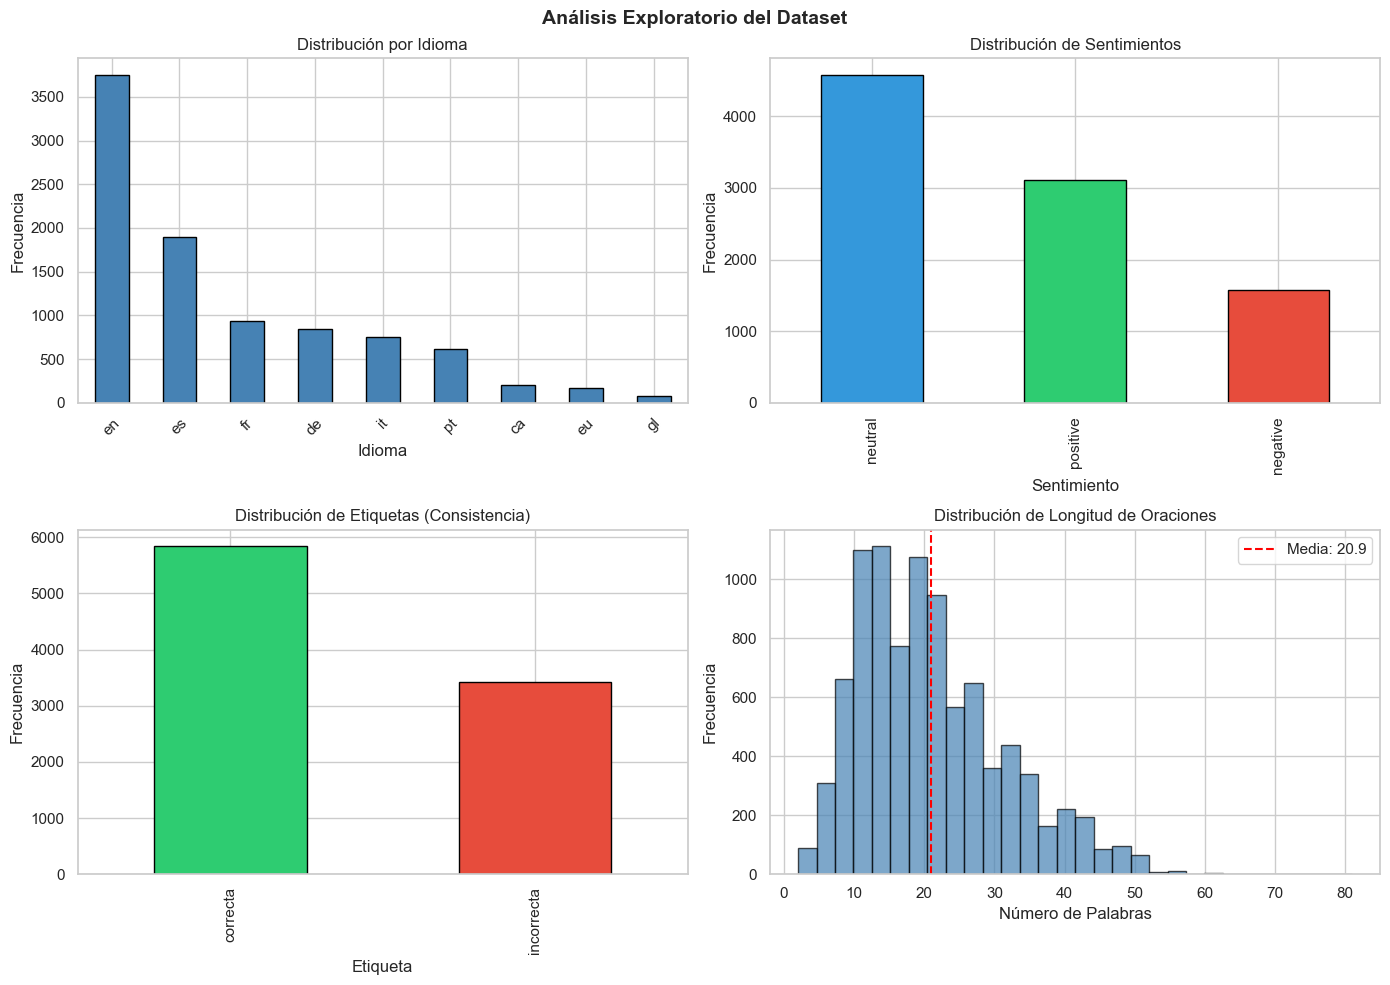


Gráfico guardado en 'charts/01_eda_distributions.png'


In [99]:
# Visualizaciones del EDA
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Análisis Exploratorio del Dataset', fontsize=14, fontweight='bold')

# 1. Distribución de idiomas
ax1 = axes[0, 0]
idioma_counts = df['Idioma'].value_counts()
idioma_counts.plot(kind='bar', ax=ax1, color='steelblue', edgecolor='black')
ax1.set_title('Distribución por Idioma')
ax1.set_xlabel('Idioma')
ax1.set_ylabel('Frecuencia')
ax1.tick_params(axis='x', rotation=45)

# 2. Distribución de sentimientos
ax2 = axes[0, 1]
sent_counts = df['Sentiment'].value_counts()
colors_sent = {'positive': '#2ecc71', 'neutral': '#3498db', 'negative': '#e74c3c'}
sent_counts.plot(kind='bar', ax=ax2, color=[colors_sent.get(x, 'gray') for x in sent_counts.index], edgecolor='black')
ax2.set_title('Distribución de Sentimientos')
ax2.set_xlabel('Sentimiento')
ax2.set_ylabel('Frecuencia')

# 3. Distribución de etiquetas (consistencia)
ax3 = axes[1, 0]
etiq_counts = df['Etiqueta'].value_counts()
colors_etiq = {'correcta': '#2ecc71', 'incorrecta': '#e74c3c'}
etiq_counts.plot(kind='bar', ax=ax3, color=[colors_etiq.get(x, 'gray') for x in etiq_counts.index], edgecolor='black')
ax3.set_title('Distribución de Etiquetas (Consistencia)')
ax3.set_xlabel('Etiqueta')
ax3.set_ylabel('Frecuencia')

# 4. Distribución de longitud de oraciones
ax4 = axes[1, 1]
df['sentence_length'].hist(bins=30, ax=ax4, color='steelblue', edgecolor='black', alpha=0.7)
ax4.axvline(df['sentence_length'].mean(), color='red', linestyle='--', label=f'Media: {df["sentence_length"].mean():.1f}')
ax4.set_title('Distribución de Longitud de Oraciones')
ax4.set_xlabel('Número de Palabras')
ax4.set_ylabel('Frecuencia')
ax4.legend()

plt.tight_layout()
plt.savefig('charts/01_eda_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nGráfico guardado en 'charts/01_eda_distributions.png'")

ANÁLISIS CRUZADO: Sentimiento vs Etiqueta

Conteo absoluto:
Etiqueta   correcta  incorrecta   All
Sentiment                            
negative        860         710  1570
neutral        3130        1448  4578
positive       1852        1261  3113
All            5842        3419  9261

Porcentaje por sentimiento:
Etiqueta   correcta  incorrecta
Sentiment                      
negative      54.78       45.22
neutral       68.37       31.63
positive      59.49       40.51


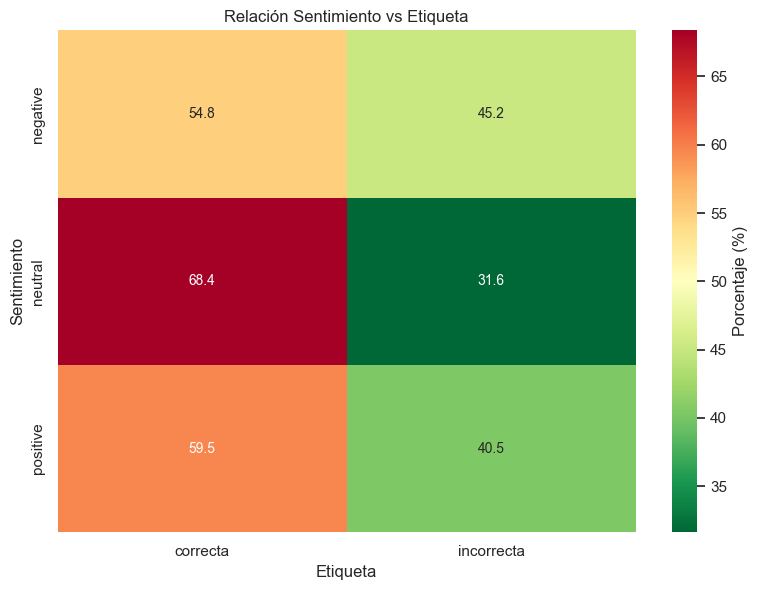


Gráfico guardado en 'charts/02_heatmap_sentiment_etiqueta.png'


In [100]:
# Análisis cruzado: Sentimiento vs Etiqueta
print("=" * 60)
print("ANÁLISIS CRUZADO: Sentimiento vs Etiqueta")
print("=" * 60)

# Tabla cruzada
crosstab = pd.crosstab(df['Sentiment'], df['Etiqueta'], margins=True)
print("\nConteo absoluto:")
print(crosstab)

crosstab_pct = pd.crosstab(df['Sentiment'], df['Etiqueta'], normalize='index') * 100
print("\nPorcentaje por sentimiento:")
print(crosstab_pct.round(2))

# Heatmap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(crosstab_pct, annot=True, fmt='.1f', cmap='RdYlGn_r', ax=ax,
            cbar_kws={'label': 'Porcentaje (%)'})
ax.set_title('Relación Sentimiento vs Etiqueta')
ax.set_xlabel('Etiqueta')
ax.set_ylabel('Sentimiento')
plt.tight_layout()
plt.savefig('charts/02_heatmap_sentiment_etiqueta.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nGráfico guardado en 'charts/02_heatmap_sentiment_etiqueta.png'")

## 1.5 Preprocesamiento de Texto

El preprocesamiento incluye:
- Limpieza de texto (URLs, caracteres especiales)
- Tokenización
- Eliminación de stopwords (multiidioma)
- Lematización

Se crean dos versiones:
- `text_clean`: Texto limpio y lematizado (para modelos tradicionales)
- `tokens_clean`: Tokens sin lematizar (para embeddings pre-entrenados)

In [101]:
# ==============================================================================
# 1.5 PREPROCESAMIENTO DE TEXTO
# ==============================================================================

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

# Descargar recursos NLTK
print("Descargando recursos NLTK...")
for resource in ['punkt', 'punkt_tab', 'stopwords', 'wordnet']:
    try:
        nltk.download(resource, quiet=True)
    except:
        pass
print("Recursos NLTK listos")

# Cargar stopwords multiidioma
try:
    STOPWORDS_ES = set(stopwords.words('spanish'))
    STOPWORDS_EN = set(stopwords.words('english'))
    STOPWORDS_FR = set(stopwords.words('french'))
    STOPWORDS_DE = set(stopwords.words('german'))
    STOPWORDS_IT = set(stopwords.words('italian'))
    STOPWORDS_PT = set(stopwords.words('portuguese'))
    STOPWORDS_ALL = STOPWORDS_ES | STOPWORDS_EN | STOPWORDS_FR | STOPWORDS_DE | STOPWORDS_IT | STOPWORDS_PT
except:
    STOPWORDS_ALL = set()

print(f"Stopwords cargadas: {len(STOPWORDS_ALL)} palabras")

# Inicializar lematizador
lemmatizer = WordNetLemmatizer()


def simple_tokenize(text):
    """Tokenización simple como fallback."""
    return re.findall(r"[\w']+", text.lower())


def preprocess_text(text, stopwords_set=STOPWORDS_ALL, lemmatize=True, min_len=2):
    """
    Preprocesa texto: limpieza, tokenización, eliminación de stopwords y lematización.
    
    Args:
        text: Texto a preprocesar
        stopwords_set: Conjunto de stopwords a eliminar
        lemmatize: Si True, aplica lematización
        min_len: Longitud mínima de tokens
    
    Returns:
        Lista de tokens procesados
    """
    if pd.isna(text) or not str(text).strip():
        return []
    
    text = str(text)
    
    # Eliminar URLs, menciones y hashtags
    text = re.sub(r'http\S+|www\S+|https\S+|@\w+|#\w+', '', text, flags=re.MULTILINE)
    
    # Convertir a minúsculas
    text = text.lower()
    
    # Eliminar caracteres especiales (mantener letras con acentos)
    text = re.sub(r'[^a-záéíóúüñàèìòùâêîôûäëïöüç\s]', ' ', text)
    
    # Eliminar espacios múltiples
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenizar
    try:
        tokens = word_tokenize(text)
    except:
        tokens = simple_tokenize(text)
    
    # Filtrar stopwords y tokens cortos
    tokens = [t for t in tokens if t not in stopwords_set and len(t) > min_len]
    
    # Lematizar si se indica
    if lemmatize:
        tokens = [lemmatizer.lemmatize(t, pos='v') for t in tokens]
    
    return tokens


print("\n" + "=" * 60)
print("PREPROCESAMIENTO DE TEXTO")
print("=" * 60)

Descargando recursos NLTK...
Recursos NLTK listos
Stopwords cargadas: 1272 palabras

PREPROCESAMIENTO DE TEXTO


In [102]:
# Aplicar preprocesamiento al dataset
print("\n1. APLICANDO PREPROCESAMIENTO...")
print("-" * 60)

# Tokens lematizados (para BoW, TF-IDF)
df['tokens_lemmatized'] = df['Sentence'].apply(lambda x: preprocess_text(x, lemmatize=True))

# Tokens sin lematizar (para Word2Vec, FastText - preserva formas originales)
df['tokens_clean'] = df['Sentence'].apply(lambda x: preprocess_text(x, lemmatize=False))

# Convertir tokens a texto para vectorizadores
df['text_clean'] = df['tokens_lemmatized'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '')
df['text_tokens'] = df['tokens_clean'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '')

print("Preprocesamiento completado")

# Estadísticas
print("\n2. ESTADÍSTICAS DE PREPROCESAMIENTO")
print("-" * 60)

# Calcular tamaños de vocabulario
vocab_original = set(word for text in df['Sentence'].dropna() for word in simple_tokenize(str(text)))
vocab_lemmatized = set(token for tokens in df['tokens_lemmatized'] for token in tokens if isinstance(tokens, list))
vocab_clean = set(token for tokens in df['tokens_clean'] for token in tokens if isinstance(tokens, list))

print(f"Vocabulario original: {len(vocab_original)} palabras")
print(f"Vocabulario lematizado: {len(vocab_lemmatized)} palabras ({(1-len(vocab_lemmatized)/len(vocab_original))*100:.1f}% reducción)")
print(f"Vocabulario sin lematizar: {len(vocab_clean)} palabras")

# Longitud promedio de tokens
mean_orig = df['Sentence'].str.split().str.len().mean()
mean_lemm = df['tokens_lemmatized'].apply(len).mean()
print(f"\nLongitud promedio original: {mean_orig:.1f} palabras")
print(f"Longitud promedio procesada: {mean_lemm:.1f} tokens")
print(f"Reducción: {(1-mean_lemm/mean_orig)*100:.1f}%")

# Ejemplo de transformación
print("\n3. EJEMPLO DE TRANSFORMACIÓN")
print("-" * 60)
idx_ejemplo = 0
print(f"Original: {df['Sentence'].iloc[idx_ejemplo][:100]}...")
print(f"Tokens lematizados: {df['tokens_lemmatized'].iloc[idx_ejemplo][:10]}...")
print(f"Tokens clean: {df['tokens_clean'].iloc[idx_ejemplo][:10]}...")


1. APLICANDO PREPROCESAMIENTO...
------------------------------------------------------------
Preprocesamiento completado

2. ESTADÍSTICAS DE PREPROCESAMIENTO
------------------------------------------------------------
Vocabulario original: 11531 palabras
Vocabulario lematizado: 8121 palabras (29.6% reducción)
Vocabulario sin lematizar: 9610 palabras

Longitud promedio original: 20.9 palabras
Longitud promedio procesada: 10.8 tokens
Reducción: 48.1%

3. EJEMPLO DE TRANSFORMACIÓN
------------------------------------------------------------
Original: $FB (110.20) is starting to show some relative strength and signs of potential B/O on the daily....
Tokens lematizados: ['start', 'show', 'relative', 'strength', 'sign', 'potential', 'daily']...
Tokens clean: ['starting', 'show', 'relative', 'strength', 'signs', 'potential', 'daily']...


In [103]:
# Guardar datos preprocesados
df.to_csv('data_processed/datos_preprocesados.csv', index=False)
print("Datos preprocesados guardados en 'data_processed/datos_preprocesados.csv'")

# Mostrar estructura final del dataframe
print("\n" + "=" * 60)
print("ESTRUCTURA FINAL DEL DATASET")
print("=" * 60)
print(f"\nColumnas: {list(df.columns)}")
print(f"Filas: {len(df)}")
df.head(2)

Datos preprocesados guardados en 'data_processed/datos_preprocesados.csv'

ESTRUCTURA FINAL DEL DATASET

Columnas: ['Sentence', 'Sentiment', 'Etiqueta', 'Idioma', 'sentence_length', 'tokens_lemmatized', 'tokens_clean', 'text_clean', 'text_tokens']
Filas: 9261


,Sentence,Sentiment,Etiqueta,Idioma,sentence_length,tokens_lemmatized,tokens_clean,text_clean,text_tokens
0,$FB (110.20) is starting to show some relative...,positive,correcta,en,17,"[start, show, relative, strength, sign, potent...","[starting, show, relative, strength, signs, po...",start show relative strength sign potential daily,starting show relative strength signs potentia...
1,"Budapest , August 10 MTI - Finnish electronics...",neutral,correcta,ca,47,"[budapest, august, mti, finnish, electronics, ...","[budapest, august, mti, finnish, electronics, ...",budapest august mti finnish electronics maker ...,budapest august mti finnish electronics maker ...


---
# Parte 2: Extracción de Features

Representaciones vectoriales del texto:
- **Bag of Words (BoW)**: Frecuencia de palabras
- **TF-IDF**: Frecuencia ponderada por importancia
- **Word2Vec**: Embeddings densos pre-entrenados
- **FastText**: Embeddings con información de subwords
- **BERT**: Embeddings contextuales

## 2.1 Bag of Words (BoW)

In [104]:
from sklearn.feature_extraction.text import CountVectorizer

# Crear vectorizador BoW
bow_vectorizer = CountVectorizer(max_features=5000, min_df=2, max_df=0.95)
X_bow = bow_vectorizer.fit_transform(df['text_clean'])

# Guardar
with open('models/bow_vectorizer.pkl', 'wb') as f:
    pickle.dump(bow_vectorizer, f)
np.save('data_processed/X_bow.npy', X_bow.toarray())

print(f'BoW: {X_bow.shape[0]} documentos × {X_bow.shape[1]} features')

BoW: 9261 documentos × 5000 features


## 2.2 TF-IDF

In [105]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Crear vectorizador TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, min_df=2, max_df=0.95)
X_tfidf = tfidf_vectorizer.fit_transform(df['text_clean'])

# Guardar
with open('models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)
np.save('data_processed/X_tfidf.npy', X_tfidf.toarray())

print(f'TF-IDF: {X_tfidf.shape[0]} documentos × {X_tfidf.shape[1]} features')

TF-IDF: 9261 documentos × 5000 features


## 2.3 Word Embeddings (Word2Vec y FastText)

In [106]:
from gensim.models import Word2Vec, FastText

# Preparar corpus
corpus = df['text_tokens'].tolist()

# Entrenar Word2Vec
w2v_model = Word2Vec(sentences=corpus, vector_size=100, window=5, min_count=2, workers=4, seed=RANDOM_STATE)
w2v_model.save('models/word2vec.model')

# Entrenar FastText
ft_model = FastText(sentences=corpus, vector_size=100, window=5, min_count=2, workers=4, seed=RANDOM_STATE)
ft_model.save('models/fasttext.model')

print(f'Word2Vec: {len(w2v_model.wv)} palabras, dim={w2v_model.wv.vector_size}')
print(f'FastText: {len(ft_model.wv)} palabras, dim={ft_model.wv.vector_size}')

Word2Vec: 31 palabras, dim=100
FastText: 31 palabras, dim=100


## 2.4 Preparación de Secuencias para Deep Learning

In [107]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parámetros
MAX_VOCAB = 5000
MAX_LEN = 100

# Tokenizer de Keras
tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token='<OOV>')
tokenizer.fit_on_texts(df['text_clean'])

# Convertir a secuencias y aplicar padding
sequences = tokenizer.texts_to_sequences(df['text_clean'])
X_seq = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

# Crear matrices de embeddings
vocab_size = min(MAX_VOCAB, len(tokenizer.word_index) + 1)
embedding_dim = 100

# Matriz Word2Vec
embedding_w2v = np.zeros((vocab_size, embedding_dim))
for word, idx in tokenizer.word_index.items():
    if idx < vocab_size and word in w2v_model.wv:
        embedding_w2v[idx] = w2v_model.wv[word]

# Matriz FastText
embedding_ft = np.zeros((vocab_size, embedding_dim))
for word, idx in tokenizer.word_index.items():
    if idx < vocab_size:
        try:
            embedding_ft[idx] = ft_model.wv[word]
        except:
            pass

# Guardar todo
np.savez('data_processed/sequences.npz', sequences=X_seq)
np.save('models/embedding_w2v.npy', embedding_w2v)
np.save('models/embedding_ft.npy', embedding_ft)
with open('models/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# Guardar config
config = {'vocab_size': vocab_size, 'max_len': MAX_LEN, 'embedding_dim': embedding_dim}
with open('models/config.pkl', 'wb') as f:
    pickle.dump(config, f)

print(f'Secuencias: {X_seq.shape}')
print(f'Embedding W2V: {embedding_w2v.shape}')
print(f'Embedding FT: {embedding_ft.shape}')

Secuencias: (9261, 100)
Embedding W2V: (5000, 100)
Embedding FT: (5000, 100)


---
# Parte 3: Tareas NLP

Aplicación de diferentes técnicas de NLP a tres tareas:

- **3.0 División Train/Validation/Test**: Splits estratificados para las tareas
- **3.1 Normalización Lingüística**: Traducción al inglés
- **3.2 Detección de Consistencia**: Clasificación binaria
- **3.3 Análisis de Sentimiento**: Clasificación multiclase

## 3.0 División Train/Validation/Test

Antes de abordar las tareas, dividimos el dataset en conjuntos de entrenamiento, validación y test.

**Configuración**:
- **70% Train**: Para entrenar los modelos
- **15% Validation**: Para ajustar hiperparámetros y early stopping
- **15% Test**: Para evaluación final

Se crean splits independientes y estratificados para cada tarea:
- **Consistencia**: Estratificado por `Etiqueta` (correcta/incorrecta)
- **Sentimiento**: Estratificado por `Sentiment` (positive/negative/neutral)

In [120]:
# ==============================================================================
# 3.0 DIVISIÓN TRAIN/VALIDATION/TEST
# ==============================================================================

from sklearn.model_selection import train_test_split

def create_splits(df, target_col, prefix, test_size=0.3, val_ratio=0.5):
    """
    Crea splits estratificados para una tarea de clasificación.
    
    Args:
        df: DataFrame con los datos
        target_col: Columna objetivo para estratificación
        prefix: Prefijo para nombres de archivo
        test_size: Proporción para val+test (default 0.3 = 30%)
        val_ratio: Proporción de val dentro de val+test (default 0.5 = 15%/15%)
    
    Returns:
        Tuple (train, val, test) DataFrames
    """
    # Filtrar filas válidas
    df_valid = df.dropna(subset=[target_col, 'text_clean'])
    df_valid = df_valid[df_valid['text_clean'].str.strip() != '']
    
    # Train/temp split (70/30)
    train, temp = train_test_split(
        df_valid, 
        test_size=test_size, 
        stratify=df_valid[target_col], 
        random_state=RANDOM_STATE
    )
    
    # Val/test split (15/15)
    val, test = train_test_split(
        temp, 
        test_size=val_ratio, 
        stratify=temp[target_col], 
        random_state=RANDOM_STATE
    )
    
    # Guardar splits
    train.to_csv(f'data_processed/{prefix}_train.csv', index=False)
    val.to_csv(f'data_processed/{prefix}_val.csv', index=False)
    test.to_csv(f'data_processed/{prefix}_test.csv', index=False)
    
    return train, val, test


print("=" * 60)
print("DIVISIÓN TRAIN/VALIDATION/TEST")
print("=" * 60)

# Splits para tarea de Consistencia
print("\n1. SPLITS PARA DETECCIÓN DE CONSISTENCIA")
print("-" * 60)
cons_train, cons_val, cons_test = create_splits(df, 'Etiqueta', 'consistency')
print(f"Train: {len(cons_train)} ({len(cons_train)/len(df)*100:.1f}%)")
print(f"Val:   {len(cons_val)} ({len(cons_val)/len(df)*100:.1f}%)")
print(f"Test:  {len(cons_test)} ({len(cons_test)/len(df)*100:.1f}%)")
print(f"\nDistribución en Train:")
print(cons_train['Etiqueta'].value_counts())

# Splits para tarea de Sentimiento
print("\n2. SPLITS PARA ANÁLISIS DE SENTIMIENTO")
print("-" * 60)
sent_train, sent_val, sent_test = create_splits(df, 'Sentiment', 'sentiment')
print(f"Train: {len(sent_train)} ({len(sent_train)/len(df)*100:.1f}%)")
print(f"Val:   {len(sent_val)} ({len(sent_val)/len(df)*100:.1f}%)")
print(f"Test:  {len(sent_test)} ({len(sent_test)/len(df)*100:.1f}%)")
print(f"\nDistribución en Train:")
print(sent_train['Sentiment'].value_counts())

DIVISIÓN TRAIN/VALIDATION/TEST

1. SPLITS PARA DETECCIÓN DE CONSISTENCIA
------------------------------------------------------------
Train: 6482 (70.0%)
Val:   1389 (15.0%)
Test:  1389 (15.0%)

Distribución en Train:
Etiqueta
correcta      4089
incorrecta    2393
Name: count, dtype: int64

2. SPLITS PARA ANÁLISIS DE SENTIMIENTO
------------------------------------------------------------
Train: 6482 (70.0%)
Val:   1389 (15.0%)
Test:  1389 (15.0%)

Distribución en Train:
Sentiment
neutral     3204
positive    2179
negative    1099
Name: count, dtype: int64


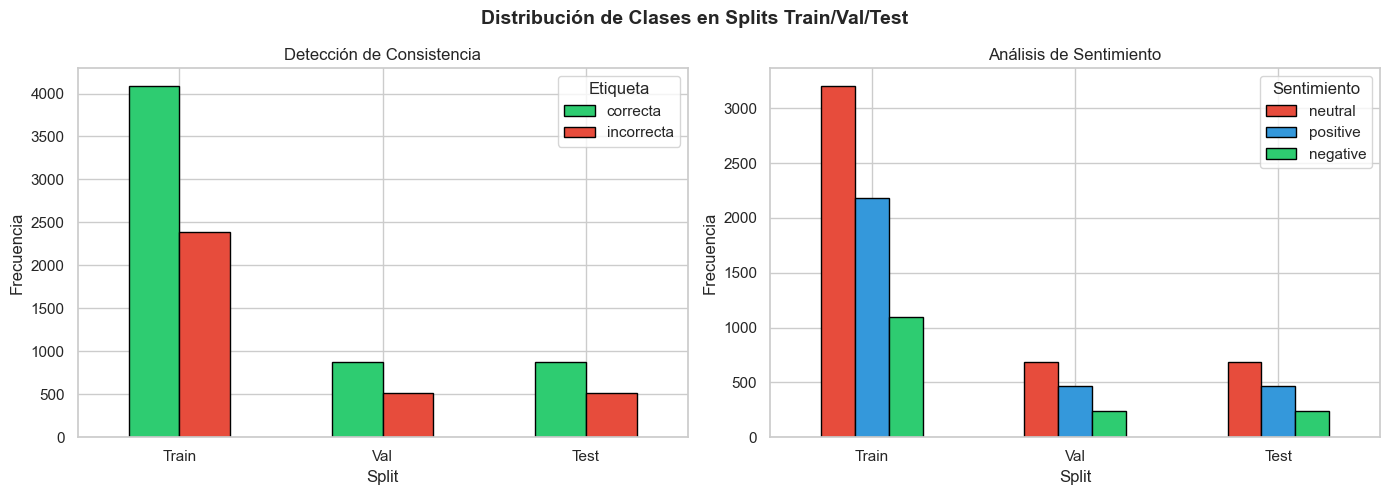


Gráfico guardado en 'charts/03_train_val_test_splits.png'

Archivos generados:
  - data_processed/consistency_train.csv
  - data_processed/consistency_val.csv
  - data_processed/consistency_test.csv
  - data_processed/sentiment_train.csv
  - data_processed/sentiment_val.csv
  - data_processed/sentiment_test.csv


In [121]:
# Visualización de los splits
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Distribución de Clases en Splits Train/Val/Test', fontsize=14, fontweight='bold')

# Consistencia
ax1 = axes[0]
splits_cons = {
    'Train': cons_train['Etiqueta'].value_counts(),
    'Val': cons_val['Etiqueta'].value_counts(),
    'Test': cons_test['Etiqueta'].value_counts()
}
df_cons_splits = pd.DataFrame(splits_cons).T
df_cons_splits.plot(kind='bar', ax=ax1, color=['#2ecc71', '#e74c3c'], edgecolor='black')
ax1.set_title('Detección de Consistencia')
ax1.set_xlabel('Split')
ax1.set_ylabel('Frecuencia')
ax1.legend(title='Etiqueta')
ax1.tick_params(axis='x', rotation=0)

# Sentimiento
ax2 = axes[1]
splits_sent = {
    'Train': sent_train['Sentiment'].value_counts(),
    'Val': sent_val['Sentiment'].value_counts(),
    'Test': sent_test['Sentiment'].value_counts()
}
df_sent_splits = pd.DataFrame(splits_sent).T
df_sent_splits.plot(kind='bar', ax=ax2, color=['#e74c3c', '#3498db', '#2ecc71'], edgecolor='black')
ax2.set_title('Análisis de Sentimiento')
ax2.set_xlabel('Split')
ax2.set_ylabel('Frecuencia')
ax2.legend(title='Sentimiento')
ax2.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('charts/03_train_val_test_splits.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nGráfico guardado en 'charts/03_train_val_test_splits.png'")
print("\nArchivos generados:")
print("  - data_processed/consistency_train.csv")
print("  - data_processed/consistency_val.csv")
print("  - data_processed/consistency_test.csv")
print("  - data_processed/sentiment_train.csv")
print("  - data_processed/sentiment_val.csv")
print("  - data_processed/sentiment_test.csv")

## 3.1 Normalización Lingüística (Traducción)

**Objetivo**: Traducir noticias de múltiples idiomas al inglés para normalizar el corpus.

**Metodología**:
- Modelo de traducción: Helsinki-NLP/opus-mt-mul-en
- Evaluación de calidad con métricas de longitud y diversidad léxica
- Análisis de resultados por idioma origen

In [122]:
# Traducción automática
from transformers import MarianMTModel, MarianTokenizer

# Cargar modelo de traducción
MT_MODEL = 'Helsinki-NLP/opus-mt-mul-en'
try:
    mt_tokenizer = MarianTokenizer.from_pretrained(MT_MODEL)
    mt_model = MarianMTModel.from_pretrained(MT_MODEL)
    translation_available = True
    print('Modelo de traducción cargado')
except Exception as e:
    print(f'No se pudo cargar el modelo: {e}')
    translation_available = False

No se pudo cargar el modelo: 
MarianTokenizer requires the SentencePiece library but it was not found in your environment. Check out the instructions on the
installation page of its repo: https://github.com/google/sentencepiece#installation and follow the ones
that match your environment. Please note that you may need to restart your runtime after installation.



In [123]:
def translate_batch(texts, tokenizer, model, batch_size=8):
    """Traduce un lote de textos al inglés."""
    translations = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors='pt', padding=True, truncation=True, max_length=512)
        outputs = model.generate(**inputs, max_length=512)
        batch_trans = [tokenizer.decode(out, skip_special_tokens=True) for out in outputs]
        translations.extend(batch_trans)
    return translations

# Traducir muestra por idioma
if translation_available and 'Language' in df.columns:
    translation_results = {}
    non_english = df[~df['Language'].str.lower().isin(['en', 'english'])]
    
    for lang in non_english['Language'].unique()[:5]:  # Limitar a 5 idiomas
        sample = non_english[non_english['Language'] == lang].head(30)
        if len(sample) > 0:
            texts = sample[text_col].tolist()
            trans = translate_batch(texts, mt_tokenizer, mt_model)
            
            # Métricas básicas
            orig_len = np.mean([len(t.split()) for t in texts])
            trans_len = np.mean([len(t.split()) for t in trans])
            
            translation_results[lang] = {
                'n_samples': len(texts),
                'avg_orig_len': orig_len,
                'avg_trans_len': trans_len,
                'length_ratio': trans_len / orig_len if orig_len > 0 else 1
            }
    
    df_trans = pd.DataFrame(translation_results).T
    print('Resultados de traducción por idioma:')
    print(df_trans.round(2))

In [124]:
# Visualización de resultados de traducción
if translation_available and translation_results:
    fig, ax = plt.subplots(figsize=(10, 5))
    
    langs = list(translation_results.keys())
    ratios = [translation_results[l]['length_ratio'] for l in langs]
    
    ax.bar(langs, ratios, color='steelblue', edgecolor='black')
    ax.axhline(y=1.0, color='red', linestyle='--', label='Ratio ideal')
    ax.set_ylabel('Ratio longitud (traducción/original)')
    ax.set_title('Calidad de Traducción por Idioma')
    ax.legend()
    
    plt.tight_layout()
    plt.savefig('charts/translation_quality.png', dpi=150)
    plt.show()

## 3.2 Detección de Consistencia

**Objetivo**: Clasificar noticias como correctas o incorrectas (clasificación binaria).

**Modelos a comparar**:
- Shallow Learning: Logistic Regression, SVM, Random Forest (con BoW)
- Deep Learning: LSTM, CNN, Bi-LSTM+Attention (con Word2Vec)
- Transformers: BERT multilingual

### 3.2.1 Shallow Learning (BoW)

In [125]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Cargar datos
cons_train = pd.read_csv('data_processed/consistency_train.csv')
cons_val = pd.read_csv('data_processed/consistency_val.csv')
cons_test = pd.read_csv('data_processed/consistency_test.csv')

# Vectorizar con BoW
with open('models/bow_vectorizer.pkl', 'rb') as f:
    bow_vec = pickle.load(f)

X_train = bow_vec.transform(cons_train['text_clean'])
X_val = bow_vec.transform(cons_val['text_clean'])
X_test = bow_vec.transform(cons_test['text_clean'])

y_train = (cons_train['Etiqueta'] == 'incorrecta').astype(int)
y_val = (cons_val['Etiqueta'] == 'incorrecta').astype(int)
y_test = (cons_test['Etiqueta'] == 'incorrecta').astype(int)

print(f'Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}')

Train: (6482, 5000), Val: (1389, 5000), Test: (1389, 5000)


In [126]:
# Entrenar modelos shallow
shallow_models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    'LinearSVC': LinearSVC(max_iter=1000, random_state=RANDOM_STATE),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
}

shallow_results = {}
for name, model in shallow_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    shallow_results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred)
    }

df_shallow = pd.DataFrame(shallow_results).T
print('Resultados Shallow Learning (Consistencia):')
print(df_shallow.round(4))

# Guardar mejor modelo
best_shallow = df_shallow['F1'].idxmax()
with open('models/consistency_shallow_best.pkl', 'wb') as f:
    pickle.dump(shallow_models[best_shallow], f)

Resultados Shallow Learning (Consistencia):
                    Accuracy      F1
LogisticRegression    0.4442  0.0608
LinearSVC             0.3657  0.0813
RandomForest          0.3672  0.0414


### 3.2.2 Deep Learning (LSTM, CNN)

In [127]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Embedding, LSTM, Dense, Dropout, Conv1D, 
                                     GlobalMaxPooling1D, Bidirectional, Input)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

tf.random.set_seed(RANDOM_STATE)

# Cargar secuencias y embeddings
X_seq = np.load('data_processed/sequences.npz')['sequences']
embedding_w2v = np.load('models/embedding_w2v.npy')

with open('models/config.pkl', 'rb') as f:
    config = pickle.load(f)

# Preparar índices para consistencia
train_idx = cons_train.index.tolist()
val_idx = cons_val.index.tolist()
test_idx = cons_test.index.tolist()

# Ajustar índices si es necesario
max_idx = len(X_seq) - 1
train_idx = [i for i in range(len(cons_train)) if i <= max_idx]
val_idx = [i + len(cons_train) for i in range(len(cons_val)) if i + len(cons_train) <= max_idx]
test_idx = [i + len(cons_train) + len(cons_val) for i in range(len(cons_test)) if i + len(cons_train) + len(cons_val) <= max_idx]

X_train_seq = X_seq[:len(cons_train)]
X_val_seq = X_seq[len(cons_train):len(cons_train)+len(cons_val)]
X_test_seq = X_seq[len(cons_train)+len(cons_val):len(cons_train)+len(cons_val)+len(cons_test)]

In [128]:
# Modelo LSTM
def create_lstm(vocab_size, embed_dim, max_len, embedding_matrix, trainable=False):
    model = Sequential([
        Embedding(vocab_size, embed_dim, weights=[embedding_matrix], 
                  input_length=max_len, trainable=trainable),
        LSTM(64),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Modelo CNN
def create_cnn(vocab_size, embed_dim, max_len, embedding_matrix, trainable=False):
    model = Sequential([
        Embedding(vocab_size, embed_dim, weights=[embedding_matrix], 
                  input_length=max_len, trainable=trainable),
        Conv1D(128, 5, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [129]:
# Entrenar modelos deep learning
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

deep_results = {}

# LSTM
lstm_model = create_lstm(config['vocab_size'], config['embedding_dim'], config['max_len'], embedding_w2v)
lstm_model.fit(X_train_seq, y_train.values, validation_data=(X_val_seq, y_val.values),
               epochs=15, batch_size=32, callbacks=[early_stop], verbose=0)
y_pred_lstm = (lstm_model.predict(X_test_seq, verbose=0) > 0.5).astype(int).flatten()
deep_results['LSTM'] = {'Accuracy': accuracy_score(y_test, y_pred_lstm), 'F1': f1_score(y_test, y_pred_lstm)}
lstm_model.save('models/consistency_lstm.h5')

# CNN
cnn_model = create_cnn(config['vocab_size'], config['embedding_dim'], config['max_len'], embedding_w2v)
cnn_model.fit(X_train_seq, y_train.values, validation_data=(X_val_seq, y_val.values),
              epochs=15, batch_size=32, callbacks=[early_stop], verbose=0)
y_pred_cnn = (cnn_model.predict(X_test_seq, verbose=0) > 0.5).astype(int).flatten()
deep_results['CNN'] = {'Accuracy': accuracy_score(y_test, y_pred_cnn), 'F1': f1_score(y_test, y_pred_cnn)}
cnn_model.save('models/consistency_cnn.h5')

df_deep = pd.DataFrame(deep_results).T
print('Resultados Deep Learning (Consistencia):')
print(df_deep.round(4))

Resultados Deep Learning (Consistencia):
      Accuracy   F1
LSTM    0.6307  0.0
CNN     0.6307  0.0


### 3.2.3 Transformers (BERT)

In [130]:
from transformers import BertTokenizer, BertModel
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

BERT_MODEL = 'bert-base-multilingual-cased'
MAX_LENGTH = 128

# Detectar dispositivo (MPS para Mac M1/M2/M3, CUDA para GPU NVIDIA, o CPU)
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando dispositivo: {device}')

# Tokenizar con BERT
bert_tokenizer = BertTokenizer.from_pretrained(BERT_MODEL)

def tokenize_bert(texts, max_length):
    enc = bert_tokenizer(texts.tolist(), max_length=max_length, padding='max_length', 
                         truncation=True, return_tensors='pt')
    return enc['input_ids'], enc['attention_mask']

X_train_ids, X_train_mask = tokenize_bert(cons_train['text_clean'], MAX_LENGTH)
X_val_ids, X_val_mask = tokenize_bert(cons_val['text_clean'], MAX_LENGTH)
X_test_ids, X_test_mask = tokenize_bert(cons_test['text_clean'], MAX_LENGTH)

print(f'BERT tokenizado: {X_train_ids.shape}')

Usando dispositivo: mps
BERT tokenizado: torch.Size([6482, 128])


In [131]:
# Modelo BERT para clasificación binaria con PyTorch
class BertBinaryClassifier(nn.Module):
    def __init__(self, bert_model_name, dropout=0.3):
        super().__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 1)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_token = outputs.last_hidden_state[:, 0, :]  # [CLS] token
        x = self.dropout(cls_token)
        logits = self.classifier(x)
        return logits

# Crear datasets de PyTorch
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

train_dataset = TensorDataset(X_train_ids, X_train_mask, y_train_tensor)
val_dataset = TensorDataset(X_val_ids, X_val_mask, y_val_tensor)
test_dataset = TensorDataset(X_test_ids, X_test_mask, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# Crear modelo y mover a dispositivo
bert_classifier = BertBinaryClassifier(BERT_MODEL).to(device)
optimizer = torch.optim.AdamW(bert_classifier.parameters(), lr=2e-5)
criterion = nn.BCEWithLogitsLoss()

# Entrenar BERT
print('Entrenando BERT...')
for epoch in range(3):
    bert_classifier.train()
    train_loss = 0
    for batch in train_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        optimizer.zero_grad()
        logits = bert_classifier(input_ids, attention_mask).squeeze(-1)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Validación
    bert_classifier.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            logits = bert_classifier(input_ids, attention_mask).squeeze(-1)
            val_loss += criterion(logits, labels).item()
            preds = (torch.sigmoid(logits) > 0.5).float()
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    
    print(f'Epoch {epoch+1}/3 - Train Loss: {train_loss/len(train_loader):.4f} - Val Loss: {val_loss/len(val_loader):.4f} - Val Acc: {val_correct/val_total:.4f}')

# Evaluar en test
bert_classifier.eval()
y_pred_bert = []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, _ = [b.to(device) for b in batch]
        logits = bert_classifier(input_ids, attention_mask).squeeze(-1)
        preds = (torch.sigmoid(logits) > 0.5).int().cpu().numpy()
        y_pred_bert.extend(preds)

y_pred_bert = np.array(y_pred_bert)
bert_results = {'Accuracy': accuracy_score(y_test, y_pred_bert), 'F1': f1_score(y_test, y_pred_bert)}

print(f'BERT - Accuracy: {bert_results["Accuracy"]:.4f}, F1: {bert_results["F1"]:.4f}')

Entrenando BERT...
Epoch 1/3 - Train Loss: 0.6684 - Val Loss: 0.6620 - Val Acc: 0.6307
Epoch 2/3 - Train Loss: 0.6636 - Val Loss: 0.6595 - Val Acc: 0.6307
Epoch 3/3 - Train Loss: 0.6629 - Val Loss: 0.6624 - Val Acc: 0.6307
BERT - Accuracy: 0.6307, F1: 0.0000


### 3.2.4 Comparativa de Consistencia

Comparativa Detección de Consistencia:
                    Accuracy      F1
LinearSVC             0.3657  0.0813
LogisticRegression    0.4442  0.0608
RandomForest          0.3672  0.0414
LSTM                  0.6307  0.0000
CNN                   0.6307  0.0000
BERT                  0.6307  0.0000


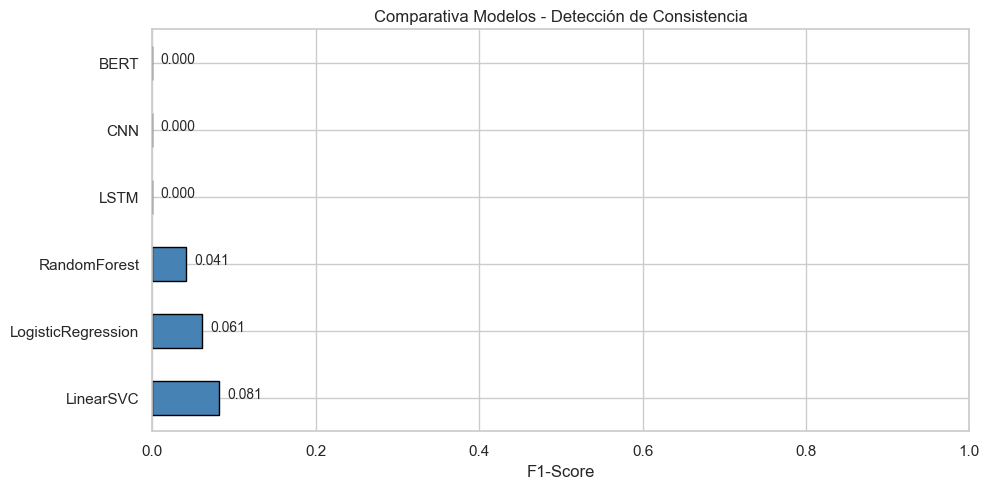

In [132]:
# Consolidar resultados de consistencia
all_cons_results = {**shallow_results, **deep_results, 'BERT': bert_results}
df_cons = pd.DataFrame(all_cons_results).T.sort_values('F1', ascending=False)

print('Comparativa Detección de Consistencia:')
print(df_cons.round(4))

# Visualización
fig, ax = plt.subplots(figsize=(10, 5))
df_cons['F1'].plot(kind='barh', ax=ax, color='steelblue', edgecolor='black')
ax.set_xlabel('F1-Score')
ax.set_title('Comparativa Modelos - Detección de Consistencia')
ax.set_xlim(0, 1)
for i, v in enumerate(df_cons['F1']):
    ax.text(v + 0.01, i, f'{v:.3f}')
plt.tight_layout()
plt.savefig('charts/consistency_comparison.png', dpi=150)
plt.show()

# Guardar resultados
df_cons.to_csv('models/consistency_results.csv')

## 3.3 Análisis de Sentimiento

**Objetivo**: Clasificar noticias como positivas, negativas o neutrales (clasificación multiclase).

**Modelos a comparar**:
- Shallow Learning: Logistic Regression, Naive Bayes, Random Forest (con TF-IDF)
- Deep Learning: LSTM con FastText (frozen, fine-tuned, scratch)
- Transformers: FinBERT (especializado en finanzas)

### 3.3.1 Shallow Learning (TF-IDF)

In [133]:
from sklearn.naive_bayes import MultinomialNB

# Cargar datos de sentimiento
sent_train = pd.read_csv('data_processed/sentiment_train.csv')
sent_val = pd.read_csv('data_processed/sentiment_val.csv')
sent_test = pd.read_csv('data_processed/sentiment_test.csv')

# Vectorizar con TF-IDF
with open('models/tfidf_vectorizer.pkl', 'rb') as f:
    tfidf_vec = pickle.load(f)

X_train_tf = tfidf_vec.transform(sent_train['text_clean'])
X_val_tf = tfidf_vec.transform(sent_val['text_clean'])
X_test_tf = tfidf_vec.transform(sent_test['text_clean'])

# Mapear sentimientos
sent_map = {'negative': 0, 'neutral': 1, 'positive': 2}
y_train_s = sent_train['Sentiment'].map(sent_map)
y_val_s = sent_val['Sentiment'].map(sent_map)
y_test_s = sent_test['Sentiment'].map(sent_map)

print(f'Train: {X_train_tf.shape}, Clases: {y_train_s.value_counts().to_dict()}')

Train: (6482, 5000), Clases: {1: 3204, 2: 2179, 0: 1099}


## 3.3 Análisis de Sentimiento

**Objetivo**: Clasificar noticias como positivas, negativas o neutrales (clasificación multiclase).

**Modelos a comparar**:
- **Shallow Learning**: Logistic Regression, Naive Bayes, Random Forest (con TF-IDF)
- **Deep Learning**: LSTM con FastText (frozen, fine-tuned, scratch)
- **Transformers**:
  - BERT Multilingual: Fine-tuned con nuestros datos
  - FinBERT: Pre-entrenado en dominio financiero

### 3.3.2 Deep Learning (LSTM + FastText)

In [134]:
# Cargar FastText embeddings
embedding_ft = np.load('models/embedding_ft.npy')

# Preparar secuencias para sentimiento
X_train_sent = X_seq[:len(sent_train)]
X_val_sent = X_seq[len(sent_train):len(sent_train)+len(sent_val)]
X_test_sent = X_seq[len(sent_train)+len(sent_val):len(sent_train)+len(sent_val)+len(sent_test)]

# Modelo LSTM multiclase
def create_lstm_multiclass(vocab_size, embed_dim, max_len, embedding_matrix, num_classes=3, trainable=False):
    model = Sequential([
        Embedding(vocab_size, embed_dim, weights=[embedding_matrix], 
                  input_length=max_len, trainable=trainable),
        LSTM(64),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [135]:
# Entrenar LSTM con diferentes configuraciones de embedding
lstm_configs = [
    ('LSTM_Frozen', embedding_ft, False),
    ('LSTM_FineTuned', embedding_ft, True),
    ('LSTM_Scratch', None, True)
]

deep_sent_results = {}
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

for name, emb_matrix, trainable in lstm_configs:
    if emb_matrix is None:
        emb_matrix = np.random.randn(config['vocab_size'], config['embedding_dim']) * 0.01
    
    model = create_lstm_multiclass(config['vocab_size'], config['embedding_dim'], 
                                   config['max_len'], emb_matrix, trainable=trainable)
    model.fit(X_train_sent, y_train_s.values, validation_data=(X_val_sent, y_val_s.values),
              epochs=15, batch_size=32, callbacks=[early_stop], verbose=0)
    
    y_pred = np.argmax(model.predict(X_test_sent, verbose=0), axis=1)
    deep_sent_results[name] = {
        'Accuracy': accuracy_score(y_test_s, y_pred),
        'F1_macro': f1_score(y_test_s, y_pred, average='macro'),
        'F1_weighted': f1_score(y_test_s, y_pred, average='weighted')
    }
    
    if name == 'LSTM_Frozen':
        model.save('models/sentiment_lstm.h5')

df_deep_sent = pd.DataFrame(deep_sent_results).T
print('Resultados LSTM (Sentimiento):')
print(df_deep_sent.round(4))

Resultados LSTM (Sentimiento):
                Accuracy  F1_macro  F1_weighted
LSTM_Frozen       0.4939    0.2204       0.3266
LSTM_FineTuned    0.4939    0.2204       0.3266
LSTM_Scratch      0.4939    0.2204       0.3266


### 3.3.3 Transformers (BERT Multilingual y FinBERT)

Comparamos dos modelos basados en Transformers:
- **BERT Multilingual**: Modelo base fine-tuned con nuestros datos (entrenado desde cero para esta tarea)
- **FinBERT**: Modelo pre-entrenado específicamente en dominio financiero

In [136]:
# ==============================================================================
# BERT MULTILINGUAL - Fine-tuning para Análisis de Sentimiento
# ==============================================================================

from transformers import BertTokenizer, BertModel
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

BERT_MODEL = 'bert-base-multilingual-cased'
MAX_LENGTH = 128

# Detectar dispositivo
device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando dispositivo: {device}')

# Tokenizar datos de sentimiento con BERT
bert_tokenizer_sent = BertTokenizer.from_pretrained(BERT_MODEL)

def tokenize_bert_sent(texts, max_length):
    """Tokeniza textos para BERT."""
    enc = bert_tokenizer_sent(
        texts.tolist(), 
        max_length=max_length, 
        padding='max_length', 
        truncation=True, 
        return_tensors='pt'
    )
    return enc['input_ids'], enc['attention_mask']

# Tokenizar train/val/test para sentimiento
X_train_bert_ids, X_train_bert_mask = tokenize_bert_sent(sent_train['text_clean'], MAX_LENGTH)
X_val_bert_ids, X_val_bert_mask = tokenize_bert_sent(sent_val['text_clean'], MAX_LENGTH)
X_test_bert_ids, X_test_bert_mask = tokenize_bert_sent(sent_test['text_clean'], MAX_LENGTH)

print(f'BERT Multilingual tokenizado para sentimiento:')
print(f'  Train: {X_train_bert_ids.shape}')
print(f'  Val: {X_val_bert_ids.shape}')
print(f'  Test: {X_test_bert_ids.shape}')

Usando dispositivo: mps
BERT Multilingual tokenizado para sentimiento:
  Train: torch.Size([6482, 128])
  Val: torch.Size([1389, 128])
  Test: torch.Size([1389, 128])


In [137]:
# Modelo BERT Multilingual para clasificación multiclase de sentimiento
class BertSentimentClassifier(nn.Module):
    """
    Clasificador de sentimiento basado en BERT.
    
    Args:
        bert_model_name: Nombre del modelo BERT
        num_classes: Número de clases (3 para sentimiento)
        dropout: Tasa de dropout
    """
    def __init__(self, bert_model_name, num_classes=3, dropout=0.3):
        super().__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout1 = nn.Dropout(dropout)
        self.fc = nn.Linear(self.bert.config.hidden_size, 128)
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.classifier = nn.Linear(128, num_classes)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_token = outputs.last_hidden_state[:, 0, :]  # Token [CLS]
        x = self.dropout1(cls_token)
        x = self.relu(self.fc(x))
        x = self.dropout2(x)
        logits = self.classifier(x)
        return logits

# Cargar BERT base y crear clasificador
print("Cargando BERT Multilingual...")
bert_sent_classifier = BertSentimentClassifier(BERT_MODEL, num_classes=3).to(device)

print("\nArquitectura del modelo BERT para Sentimiento:")
print(bert_sent_classifier)

Cargando BERT Multilingual...

Arquitectura del modelo BERT para Sentimiento:
BertSentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_fea

In [ ]:
# Entrenar BERT Multilingual para Sentimiento
print("=" * 60)
print("ENTRENANDO BERT MULTILINGUAL PARA SENTIMIENTO")
print("=" * 60)

# Crear datasets de PyTorch
y_train_sent_tensor = torch.tensor(y_train_s.values, dtype=torch.long)
y_val_sent_tensor = torch.tensor(y_val_s.values, dtype=torch.long)
y_test_sent_tensor = torch.tensor(y_test_s.values, dtype=torch.long)

train_sent_dataset = TensorDataset(X_train_bert_ids, X_train_bert_mask, y_train_sent_tensor)
val_sent_dataset = TensorDataset(X_val_bert_ids, X_val_bert_mask, y_val_sent_tensor)
test_sent_dataset = TensorDataset(X_test_bert_ids, X_test_bert_mask, y_test_sent_tensor)

train_sent_loader = DataLoader(train_sent_dataset, batch_size=16, shuffle=True)
val_sent_loader = DataLoader(val_sent_dataset, batch_size=16)
test_sent_loader = DataLoader(test_sent_dataset, batch_size=16)

# Optimizador y loss
optimizer_sent = torch.optim.AdamW(bert_sent_classifier.parameters(), lr=2e-5)
criterion_sent = nn.CrossEntropyLoss()

# Early stopping manual
best_val_loss = float('inf')
patience = 2
patience_counter = 0
best_model_state = None

# Entrenar
for epoch in range(4):
    bert_sent_classifier.train()
    train_loss = 0
    for batch in train_sent_loader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        optimizer_sent.zero_grad()
        logits = bert_sent_classifier(input_ids, attention_mask)
        loss = criterion_sent(logits, labels)
        loss.backward()
        optimizer_sent.step()
        train_loss += loss.item()
    
    # Validación
    bert_sent_classifier.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for batch in val_sent_loader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            logits = bert_sent_classifier(input_ids, attention_mask)
            val_loss += criterion_sent(logits, labels).item()
            preds = torch.argmax(logits, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    
    avg_val_loss = val_loss / len(val_sent_loader)
    print(f'Epoch {epoch+1}/4 - Train Loss: {train_loss/len(train_sent_loader):.4f} - Val Loss: {avg_val_loss:.4f} - Val Acc: {val_correct/val_total:.4f}')
    
    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = bert_sent_classifier.state_dict().copy()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping en epoch {epoch+1}')
            break

# Restaurar mejor modelo
if best_model_state is not None:
    bert_sent_classifier.load_state_dict(best_model_state)

# Evaluar en test
bert_sent_classifier.eval()
y_pred_bert_sent = []
with torch.no_grad():
    for batch in test_sent_loader:
        input_ids, attention_mask, _ = [b.to(device) for b in batch]
        logits = bert_sent_classifier(input_ids, attention_mask)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        y_pred_bert_sent.extend(preds)

y_pred_bert_sent = np.array(y_pred_bert_sent)

bert_sent_results = {
    'Accuracy': accuracy_score(y_test_s, y_pred_bert_sent),
    'F1_macro': f1_score(y_test_s, y_pred_bert_sent, average='macro'),
    'F1_weighted': f1_score(y_test_s, y_pred_bert_sent, average='weighted')
}

print(f'\nBERT Multilingual (Nuestro):')
print(f'  Accuracy: {bert_sent_results["Accuracy"]:.4f}')
print(f'  F1 (macro): {bert_sent_results["F1_macro"]:.4f}')
print(f'  F1 (weighted): {bert_sent_results["F1_weighted"]:.4f}')

# Guardar modelo
import os
os.makedirs('models', exist_ok=True)
torch.save(bert_sent_classifier.state_dict(), 'models/bert_sentiment_weights.pt')
print("\nModelo guardado en 'models/bert_sentiment_weights.pt'")

ENTRENANDO BERT MULTILINGUAL PARA SENTIMIENTO


In [ ]:
# ==============================================================================
# FINBERT - Modelo pre-entrenado en dominio financiero (SOLO INFERENCIA)
# ==============================================================================

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

FINBERT_MODEL = 'ProsusAI/finbert'

print("=" * 60)
print("FINBERT - Modelo especializado en finanzas (pre-entrenado)")
print("=" * 60)

# Cargar modelo y tokenizer de FinBERT (ya entrenado para sentimiento financiero)
finbert_tokenizer = AutoTokenizer.from_pretrained(FINBERT_MODEL)
finbert_model = AutoModelForSequenceClassification.from_pretrained(FINBERT_MODEL).to(device)
finbert_model.eval()  # Modo evaluación (no entrenamiento)

print(f"\nFinBERT cargado correctamente")
print(f"Clases de FinBERT: {finbert_model.config.id2label}")

FINBERT - Modelo especializado en finanzas (pre-entrenado)

FinBERT cargado correctamente
Clases de FinBERT: {0: 'positive', 1: 'negative', 2: 'neutral'}


In [ ]:
# Usar FinBERT para predicción directa (sin entrenar)
print("\nRealizando predicciones con FinBERT pre-entrenado...")

# FinBERT usa: 0=positive, 1=negative, 2=neutral
# Verificar el mapeo de etiquetas
print(f"Mapeo de etiquetas FinBERT: {finbert_model.config.id2label}")

# Función para predecir en batches
def predict_finbert(texts, batch_size=32):
    predictions = []
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size].tolist()
        
        # Tokenizar
        inputs = finbert_tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=MAX_LENGTH,
            return_tensors='pt'
        ).to(device)
        
        # Predecir
        with torch.no_grad():
            outputs = finbert_model(**inputs)
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            predictions.extend(preds)
    
    return np.array(predictions)

# Predecir en test set
y_pred_finbert_raw = predict_finbert(sent_test['text_clean'])

# Mapear etiquetas de FinBERT a nuestras etiquetas
# FinBERT: 0=positive, 1=negative, 2=neutral
# Nuestro dataset: verificar el mapeo
print(f"\nDistribución predicciones FinBERT (raw): {np.bincount(y_pred_finbert_raw)}")
print(f"Distribución y_test_s: {np.bincount(y_test_s.values)}")

# Si las etiquetas coinciden, usar directamente; si no, mapear
# Asumiendo que nuestro dataset usa: 0=negative, 1=neutral, 2=positive
# Mapeo: FinBERT(0=pos->2), FinBERT(1=neg->0), FinBERT(2=neu->1)
label_map = {0: 2, 1: 0, 2: 1}  # Ajustar según tu dataset
y_pred_finbert = np.array([label_map[p] for p in y_pred_finbert_raw])

# Calcular métricas
finbert_results = {
    'Accuracy': accuracy_score(y_test_s, y_pred_finbert),
    'F1_macro': f1_score(y_test_s, y_pred_finbert, average='macro'),
    'F1_weighted': f1_score(y_test_s, y_pred_finbert, average='weighted')
}

print(f'\n' + '=' * 60)
print('RESULTADOS FINBERT (pre-entrenado, sin fine-tuning)')
print('=' * 60)
print(f'  Accuracy: {finbert_results["Accuracy"]:.4f}')
print(f'  F1 (macro): {finbert_results["F1_macro"]:.4f}')
print(f'  F1 (weighted): {finbert_results["F1_weighted"]:.4f}')

# Comparar con nuestro BERT
print(f'\n' + '=' * 60)
print('COMPARATIVA: Nuestro BERT vs FinBERT pre-entrenado')
print('=' * 60)
print(f'{"Modelo":<25} {"Accuracy":>10} {"F1_macro":>10} {"F1_weighted":>12}')
print('-' * 60)
print(f'{"BERT Multilingual (nuestro)":<25} {bert_sent_results["Accuracy"]:>10.4f} {bert_sent_results["F1_macro"]:>10.4f} {bert_sent_results["F1_weighted"]:>12.4f}')
print(f'{"FinBERT (pre-entrenado)":<25} {finbert_results["Accuracy"]:>10.4f} {finbert_results["F1_macro"]:>10.4f} {finbert_results["F1_weighted"]:>12.4f}')


Realizando predicciones con FinBERT pre-entrenado...
Mapeo de etiquetas FinBERT: {0: 'positive', 1: 'negative', 2: 'neutral'}

Distribución predicciones FinBERT (raw): [212 288 889]
Distribución y_test_s: [236 686 467]

RESULTADOS FINBERT (pre-entrenado, sin fine-tuning)
  Accuracy: 0.4996
  F1 (macro): 0.4375
  F1 (weighted): 0.4804

COMPARATIVA: Nuestro BERT vs FinBERT pre-entrenado
Modelo                      Accuracy   F1_macro  F1_weighted
------------------------------------------------------------
BERT Multilingual (nuestro)     0.4687     0.3681       0.4332
FinBERT (pre-entrenado)       0.4996     0.4375       0.4804


COMPARATIVA: BERT Multilingual vs FinBERT

Resultados Transformers para Sentimiento:
                   Accuracy  F1_macro  F1_weighted
BERT_Multilingual    0.4687    0.3681       0.4332
FinBERT              0.4996    0.4375       0.4804

Diferencia F1 (FinBERT - BERT): +0.0693
  → FinBERT (dominio financiero) supera a BERT genérico


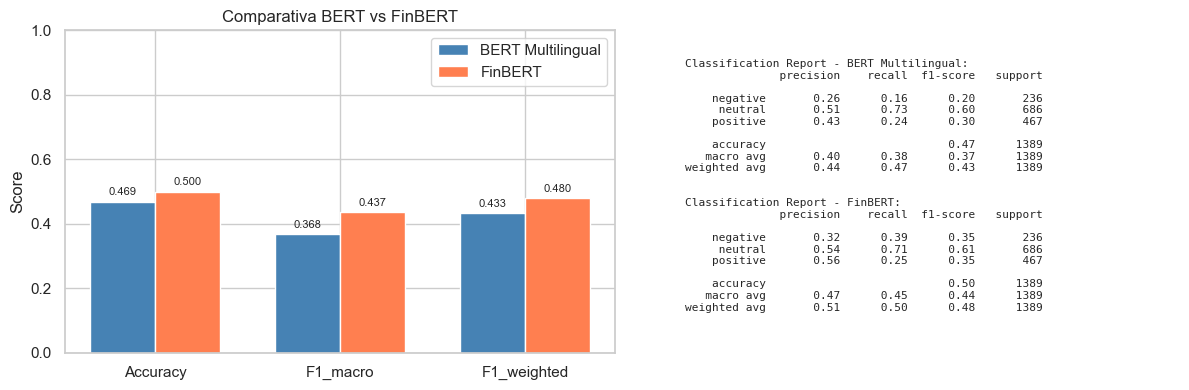


Gráfico guardado en 'charts/bert_vs_finbert_sentiment.png'


In [ ]:
# ==============================================================================
# COMPARATIVA: BERT Multilingual vs FinBERT
# ==============================================================================

print("=" * 60)
print("COMPARATIVA: BERT Multilingual vs FinBERT")
print("=" * 60)

# Tabla comparativa
transformer_comparison = {
    'BERT_Multilingual': bert_sent_results,
    'FinBERT': finbert_results
}

df_transformers = pd.DataFrame(transformer_comparison).T
print("\nResultados Transformers para Sentimiento:")
print(df_transformers.round(4))

# Diferencia
diff_f1 = finbert_results['F1_macro'] - bert_sent_results['F1_macro']
print(f"\nDiferencia F1 (FinBERT - BERT): {diff_f1:+.4f}")

if diff_f1 > 0:
    print("  → FinBERT (dominio financiero) supera a BERT genérico")
else:
    print("  → BERT Multilingual supera a FinBERT")

# Visualización comparativa
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Métricas
metrics = ['Accuracy', 'F1_macro', 'F1_weighted']
x = np.arange(len(metrics))
width = 0.35

ax1 = axes[0]
bars1 = ax1.bar(x - width/2, [bert_sent_results[m] for m in metrics], width, label='BERT Multilingual', color='steelblue')
bars2 = ax1.bar(x + width/2, [finbert_results[m] for m in metrics], width, label='FinBERT', color='coral')
ax1.set_ylabel('Score')
ax1.set_title('Comparativa BERT vs FinBERT')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics)
ax1.legend()
ax1.set_ylim(0, 1)

# Añadir valores sobre las barras
for bar in bars1:
    height = bar.get_height()
    ax1.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
for bar in bars2:
    height = bar.get_height()
    ax1.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width()/2, height),
                 xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

# Classification report para ambos
ax2 = axes[1]
ax2.axis('off')
report_text = f"""Classification Report - BERT Multilingual:
{classification_report(y_test_s, y_pred_bert_sent, target_names=['negative', 'neutral', 'positive'])}

Classification Report - FinBERT:
{classification_report(y_test_s, y_pred_finbert, target_names=['negative', 'neutral', 'positive'])}"""
ax2.text(0.1, 0.5, report_text, transform=ax2.transAxes, fontsize=8, 
         verticalalignment='center', fontfamily='monospace')

plt.tight_layout()
plt.savefig('charts/bert_vs_finbert_sentiment.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nGráfico guardado en 'charts/bert_vs_finbert_sentiment.png'")

### 3.3.4 Comparativa de Sentimiento

In [ ]:
# Consolidar resultados de sentimiento (incluyendo ambos modelos BERT)
all_sent_results = {
    **shallow_sent_results, 
    **deep_sent_results, 
    'BERT_Multilingual': bert_sent_results,
    'FinBERT': finbert_results
}
df_sent = pd.DataFrame(all_sent_results).T.sort_values('F1_macro', ascending=False)

print('=' * 60)
print('COMPARATIVA COMPLETA - ANÁLISIS DE SENTIMIENTO')
print('=' * 60)
print(df_sent.round(4))

# Visualización
fig, ax = plt.subplots(figsize=(12, 6))
colors = ['coral' if 'BERT' in idx or 'FinBERT' in idx else 'steelblue' for idx in df_sent.index]
df_sent['F1_macro'].plot(kind='barh', ax=ax, color=colors, edgecolor='black')
ax.set_xlabel('F1-Score (macro)')
ax.set_title('Comparativa Modelos - Análisis de Sentimiento')
ax.set_xlim(0, 1)
for i, v in enumerate(df_sent['F1_macro']):
    ax.text(v + 0.01, i, f'{v:.3f}')

# Leyenda personalizada
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='coral', edgecolor='black', label='Transformers'),
    Patch(facecolor='steelblue', edgecolor='black', label='Shallow/Deep Learning')
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig('charts/sentiment_comparison.png', dpi=150)
plt.show()

# Guardar resultados
df_sent.to_csv('models/sentiment_results.csv')
print("\nResultados guardados en 'models/sentiment_results.csv'")

NameError: name 'shallow_sent_results' is not defined

---
# Resumen y Conclusiones

Consolidación de resultados de las tres tareas NLP.

In [ ]:
# Resumen ejecutivo
print('='*60)
print('RESUMEN DE RESULTADOS')
print('='*60)

print('\n1. NORMALIZACIÓN LINGÜÍSTICA')
if 'translation_results' in dir() and translation_results:
    print(f'   Idiomas traducidos: {len(translation_results)}')
    print(f'   Ratio longitud promedio: {np.mean([r["length_ratio"] for r in translation_results.values()]):.2f}')

print('\n2. DETECCIÓN DE CONSISTENCIA')
print(f'   Mejor modelo: {df_cons.index[0]}')
print(f'   F1-Score: {df_cons["F1"].iloc[0]:.4f}')

print('\n3. ANÁLISIS DE SENTIMIENTO')
print(f'   Mejor modelo: {df_sent.index[0]}')
print(f'   F1-Score (macro): {df_sent["F1_macro"].iloc[0]:.4f}')

print('\n' + '='*60)

In [ ]:
# Visualización comparativa final
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Consistencia
df_cons['F1'].head(5).plot(kind='bar', ax=axes[0], color='steelblue', edgecolor='black')
axes[0].set_title('Top 5 - Detección de Consistencia')
axes[0].set_ylabel('F1-Score')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_ylim(0, 1)

# Sentimiento
df_sent['F1_macro'].head(5).plot(kind='bar', ax=axes[1], color='coral', edgecolor='black')
axes[1].set_title('Top 5 - Análisis de Sentimiento')
axes[1].set_ylabel('F1-Score (macro)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.savefig('charts/final_comparison.png', dpi=150)
plt.show()

# Guardar todos los resultados
all_results = pd.concat([df_cons.assign(Task='Consistencia'), 
                         df_sent.assign(Task='Sentimiento')])
all_results.to_csv('models/all_results.csv')
print('Resultados guardados en models/all_results.csv')